In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
import copy
%matplotlib inline


SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE/1.2)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

['V' 'B' 'R' 'U' 'I' 'gp' 'rp' 'ip'] [552.34811511 438.10138348 645.14343628 365.05415772 885.89158815
 475.82711764 624.7496809  753.83966934]
{'V': 552.3481151146556, 'B': 438.1013834799633, 'R': 645.143436280511, 'U': 365.05415772076145, 'I': 885.8915881451093, 'gp': 475.8271176361976, 'rp': 624.7496808958792, 'ip': 753.8396693376702}


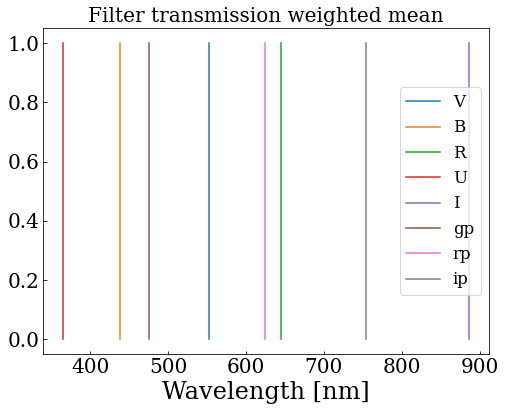

In [2]:
# read in filterdata
d = ascii.read('../wmn_PROMPT+LCOGT_filters.txt')

filt, wmean  = np.array(d['FILT']),np.array(d['WMEAN'])
print (filt,wmean)

wmean_dict = {}
for i in range(len(filt)):
    plt.plot([wmean[i]]*2,[0,1],label=filt[i])
    wmean_dict[filt[i]] = wmean[i]
print (wmean_dict)

plt.legend()
plt.xlabel('Wavelength [nm]')
plt.title("Filter transmission weighted mean")
plt.show()


In [3]:
# Read in J0600 data
J0600_dat = ascii.read('../asas-sn-J060000/J0600_all.ecsv')
obs_mask = J0600_dat['Observer Code'] == 'HMB'


filters = np.array(J0600_dat['Band'][obs_mask])
mag = np.array(J0600_dat['Magnitude'][obs_mask])
epoch = np.array(J0600_dat['MJD'][obs_mask])
Nrow = len(J0600_dat['JD'][obs_mask])

print (J0600_dat[0])

      JD      Magnitude Uncertainty HQuncertainty Band Observer Code Comment Code(s) Comp Star 1 Comp Star 2 Charts Comments Transfomed Airmass Validation Flag Cmag Kmag HJD Star Name Observer Affiliation Measurement Method Grouping Method ADS Reference Digitizer Credit        MJD        LAT LON J.D.-2400000 rel_flux_T1 rel_flux_err_T1 rel_flux_SNR_T1 tot_C_cnts tot_C_err lco_filename ﻿Timestamp (JD) SNR Inst Mag (Centroid) Magnitude (Centroid) Exposure Seconds Filename JD (Mean) Mean - Obs Mag col11 col12 mag_err FWHM BJD SKY FLUX ERRFLUX deltamag Magcorr
------------- --------- ----------- ------------- ---- ------------- --------------- ----------- ----------- ------ -------- ---------- ------- --------------- ---- ---- --- --------- -------------------- ------------------ --------------- ------------- --------- ------ ----------------- --- --- ------------ ----------- --------------- --------------- ---------- --------- ------------ --------------- --- ------------------- ---------

['V' 'B' 'R' 'U' 'I' 'gp' 'rp' 'ip']


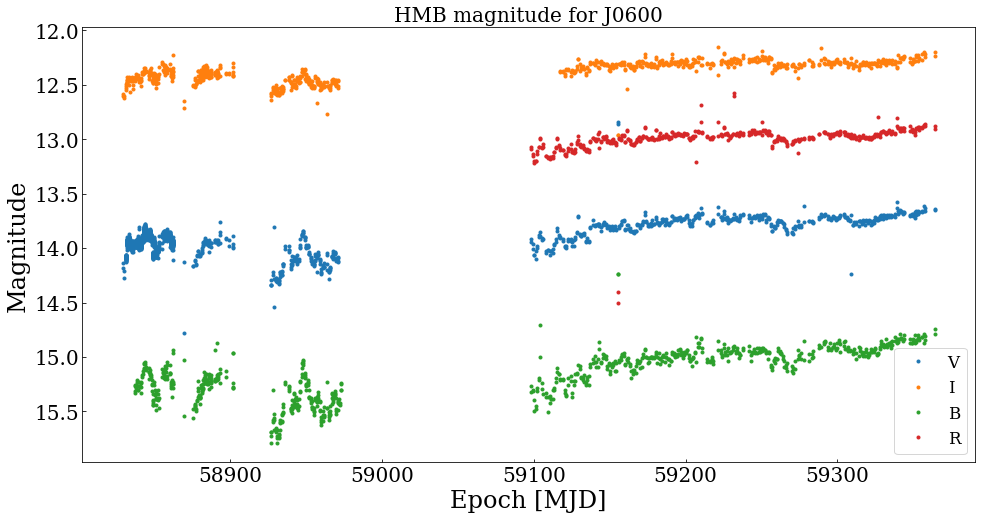

In [4]:
# Make a mask for all the filters:
J0600_filt = [] #list of the different filters
NimgINf = {} #dictionary of number of images for each filter
for f in filters:
    if f not in J0600_filt:
        J0600_filt.append(f)
        NimgINf[f] = 1
    else:
        NimgINf[f] +=1
print (filt)

fmask = {}
for f in J0600_filt:
    fmask[f] = filters == f

plt.figure(figsize=(16,8))
for f in J0600_filt:
    plt.errorbar(epoch[fmask[f]],mag[fmask[f]],fmt='.',label=f)
plt.legend()
plt.gca().invert_yaxis()
plt.title('HMB magnitude for J0600')
plt.ylabel("Magnitude")
plt.xlabel("Epoch [MJD]")
plt.show()

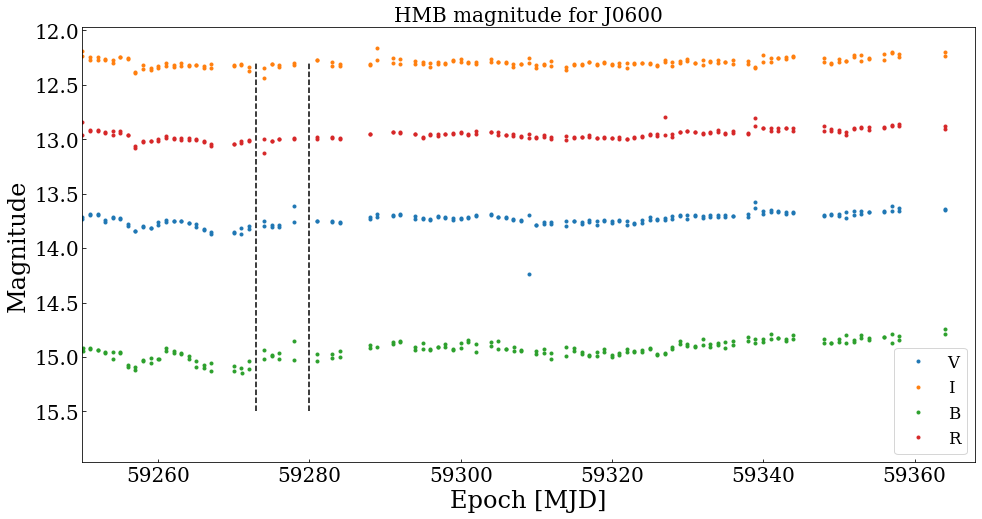

{'V': 0.14124999999999943, 'I': 0.0963750000000001, 'B': 0.17662500000000136, 'R': 0.11849999999999916}


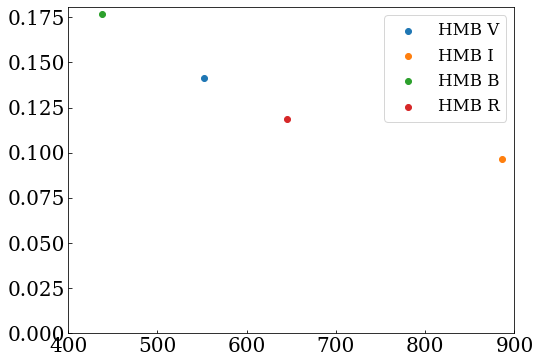

In [98]:
#Last blob of LCOGT data between 59273 & 59280 MJD

plt.figure(figsize=(16,8))
plt.plot([59273]*2,[15.5,12.3],c='black',linestyle='--')
plt.plot([59280]*2,[15.5,12.3],c='black',linestyle='--')
for f in J0600_filt:
    plt.errorbar(epoch[fmask[f]],mag[fmask[f]],fmt='.',label=f)
plt.legend()
plt.gca().invert_yaxis()
plt.title('HMB magnitude for J0600')
plt.ylabel("Magnitude")
plt.xlabel("Epoch [MJD]")
plt.axis(xmin=59250,xmax=59368)
plt.show()

HMB_dmagdict = {}
for f in ['V','I','B','R']:
    mask1 = (epoch[fmask[f]]>59273) * (epoch[fmask[f]]<59280)
    mag1 = np.median(mag[fmask[f]][mask1])
    mask2 = epoch[fmask[f]] > 59355
    mag2 = np.mean(mag[fmask[f]][mask2])
    #print (mag2)
    #print (np.mean(mag[fmask[f]][epoch[fmask[f]] > 59355]))
    HMB_dmagdict[f] = mag1-mag2
print (HMB_dmagdict)


for f in J0600_filt:
    plt.scatter(wmean_dict[f],HMB_dmagdict[f],label='HMB '+f,zorder=1)
plt.legend()
plt.axis(ymin=0,xmin=400,xmax=900)
plt.show()

In [102]:
# Go from dicts to lists
HMB_dmag = []
HMB_wmean = []
for f in ['B','V','R','I']:
    HMB_dmag.append(HMB_dmagdict[f])
    HMB_wmean.append(wmean_dict[f])
HMB_dmag = np.array(HMB_dmag)
HMB_wmean = np.array(HMB_wmean)

# Fit line through filter depths
from scipy import optimize
def linear(x,a,b):
    return (a*x) + b
def exponent(x,A,alph,x0,B):
    return A*np.exp(-alph*(x-x0))+B

popt1, pcov1 = optimize.curve_fit(linear, HMB_wmean[:-1],HMB_dmag[:-1])
popt2, pcov2 = optimize.curve_fit(exponent, HMB_wmean,HMB_dmag,p0=[0.125,0.1,650,0.1])
print (popt1)
print (popt2)
print (popt3)

[-2.81837531e-04  2.99115491e-01]
[4.17548405e-02 4.49246835e-03 6.17877676e+02 8.33989495e-02]
[ 1.13065953e-06 -1.75298856e-03  7.69308456e-01]


<ipython-input-102-a487c92fea79>:15: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-alph*(x-x0))+B
/home/bartjuh60/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


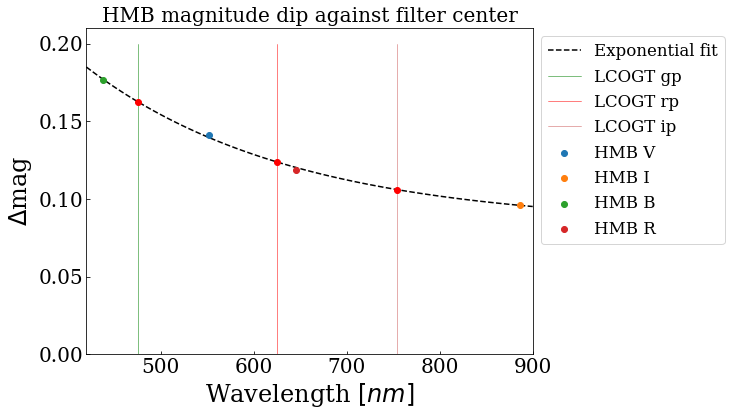

In [115]:
# Plot depth of curve against filter wmean
filt_c = {'gp':'g','rp':'r','ip':'indianred'}
x = np.linspace(400,900,100)
#plt.plot(x,linear(x,*popt1),c='black',linestyle='-',zorder=0)
plt.plot(x,exponent(x,*popt2),c='black',linestyle='--',zorder=0,label='Exponential fit')
for f in ['gp','rp','ip']:
    plt.plot([wmean_dict[f]]*2,[0,0.2],c=filt_c[f],zorder=1,linewidth=0.5,label="LCOGT "+f)
for f in J0600_filt:
    plt.scatter(wmean_dict[f],HMB_dmagdict[f],label='HMB '+f,zorder=1)



LCOGT_wmean = []
for f in ['gp','rp','ip']:
    LCOGT_wmean.append(wmean_dict[f])
LCOGT_wmean = np.array(LCOGT_wmean)

#LCOGT_dmag = linear(LCOGT_wmean,*popt1)
LCOGT_dmag = exponent(LCOGT_wmean,*popt2)

plt.legend(bbox_to_anchor=(1, 1))
plt.axis(ymin=0,xmin=420,xmax=900)
plt.scatter(LCOGT_wmean,LCOGT_dmag,zorder=5,c='r')
plt.xlabel("Wavelength $[nm]$")
plt.ylabel("$\Delta$mag")
plt.title("HMB magnitude dip against filter center")
plt.show()

In [104]:
fname = 'LCOGT_ZP.txt'
fcont = Table([['gp','rp','ip'],LCOGT_dmag],names=['FILT','DMAG'])
ascii.write(fcont,fname,overwrite=True)